In [1]:
# try the imports
import os
import torch
import math
import numpy as np
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import skimage
from descarteslabs import Storage, Auth
%pip install torchsummary
from torchsummary import summary
sys.path.append("../")
import constants
from tqdm.notebook import tqdm
sys.path.append('../UI_Labeling')
import config
from torch.utils.data import Dataset, DataLoader


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(torch.__version__)

1.7.1+cpu


In [3]:
#Variables
model_name = "b_i_hsi"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class Combo_BI_Dataset(Dataset):
    """
    Dataset for country/ies DL Sentinel2 10-channel imagery.
    """
    def __init__(self, DS_Name, balance=False, limit=0, mode="full"):
        super(Combo_BI_Dataset, self).__init__()
        self.df=pd.DataFrame()
        
        def add_dataset(dataset_name):
            df=pd.read_csv("Image_Datasets/"+dataset_name+'/metadata.csv')
            positives=0
            negatives=0
            if balance:
                confirmed={'Image':{},'Label':{},'Geometry':{}}
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in df['Label'].keys():
                    if df['Label'][idx]:
                        positives+=1
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                    else:
                        negatives+=1
                        denied['Image'][idx]=df['Image'][idx]
                        denied['Label'][idx]=df['Label'][idx]
                        denied['Geometry'][idx]=df['Geometry'][idx]
                print('positives:',positives,'negatives:',negatives)    
                if limit:
                    random.seed(constants.RANDOM_STATE)
                    sample_keys=random.sample(list(confirmed['Image'].keys()),min([len(confirmed['Image']),limit]))
                    confirmed={'Image':{},'Label':{},'Geometry':{}}
                    for idx in sample_keys:
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                random.seed(constants.RANDOM_STATE)
                sample_keys=random.sample(list(denied['Image'].keys()),min([len(denied['Image']),math.ceil((len(confirmed['Image'])*3))]))
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in sample_keys:
                    denied['Image'][idx]=df['Image'][idx]
                    denied['Label'][idx]=df['Label'][idx]
                    denied['Geometry'][idx]=df['Geometry'][idx]
                confirmed['Image'].update(denied['Image'])
                confirmed['Label'].update(denied['Label'])
                confirmed['Geometry'].update(denied['Geometry'])
                df=pd.DataFrame().from_dict(confirmed)
            #"""
            df["Image"]='Image_Datasets/'+dataset_name+'/'+df["Image"]
            df=df[['Image','Label']]
            return df
            
    # ADD DATASETS HERE FOR TRAINING
        
        self.df = pd.concat([self.df,add_dataset(DS_Name)])
        
    # END EDITABLES
        
        self.df = self.df.sample(frac=1, random_state=constants.RANDOM_STATE)
        
        if mode == "tiny":
            self.df = self.df.sample(frac=.05, random_state=constants.RANDOM_STATE)
        
    
    def __getitem__(self, idx):
        file_name, label = self.df.iloc[idx]
        img = torch.Tensor(np.load(file_name)).to(device)
        label = torch.Tensor([label]).to(device)
        
        return img, label
        
        
    def __len__(self):
        return len(self.df)


In [5]:
from torchvision.models import resnet18
import torch.nn as nn

class Resnet(torch.nn.Module):
    def __init__(self, num_channels, image_width, device=None, pretrained=False):
        super(Resnet, self).__init__()
        self.device = device        
        self.resnet = resnet18(pretrained=pretrained)
        self.resnet.conv1 = torch.nn.Conv2d(num_channels, image_width, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 256).to(device)
        self.final_fc = torch.nn.Linear(256, 1).to(device)
        
        self.resnet = self.resnet.to(device)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        resnet_output = self.resnet(x)
        outputs = self.final_fc(resnet_output)
        outputs = self.sigmoid(outputs)
        return outputs
    

In [6]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_iter, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    return running_loss / batch_iter
        
        
def evaluate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    #with torch.no_grad():
    all_labels = []
    all_preds = []
    all_outputs = []
    all_inputs=[]
    for batch_iter, (inputs, labels) in enumerate(val_loader):
        all_inputs.append(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        preds = (outputs > .5).astype('int')

        all_labels.append(labels)
        all_preds.append(preds)
        all_outputs.append(outputs)

    all_labels = np.array([label for vec in all_labels for label in vec])
    all_preds = np.stack([pred for vec in all_preds for pred in vec])
    all_outputs = np.stack([output for vec in all_outputs for output in vec])
    val_acc = np.mean((all_labels == all_preds).astype('int'))

    return val_acc, running_loss / batch_iter, all_labels, all_outputs,all_inputs

def save_checkpoint(logdir, model, optimizer, epoch, loss, lr, best=None):
    """
    Saves model checkpoint after each epoch
    logdir: Log directory
    model: model to save
    optimizer: optimizer to save
    epoch: epoch to save on
    loss: loss to log
    lr: learning rate to log
    best: An optional string used to specify which validation method this best
    checkpoint is for
    """
    checkpoint_dir = os.path.join(logdir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    if best:
        print(f"Saving checkpoint, {best}.")
        checkpoint_path = "{}/best_{}.pth".format(checkpoint_dir, best)
    else:
        checkpoint_path = "{}/lr{}_epoch{}.pth".format(checkpoint_dir, lr, epoch)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)

    if not best:
        print("Saving checkpoint to lr{}_epoch{}".format(lr, epoch))
        

def load_checkpoint(model_checkpoint, model, device, optimizer=None):
    """
    Loads a pretrained checkpoint to continue training
    model_checkpoint: Path of the model_checkpoint that ends with .pth
    model: model to load to
    device: devide to load on (gpu/cpu)
    optimizer (optional): optimize to load state to
    """
    checkpoint = torch.load(model_checkpoint, map_location=device)
    print('Loaded best state dict from epoch: {}'.format(checkpoint["epoch"]))
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model

In [7]:
dataset=[]
train_dset=None
val_dset=None
#Commend or uncomment for datasets you'd like to add.
#dataset.append(Combo_BI_Dataset('bangladesh_dl_dataset',True,858))
#dataset.append(Combo_BI_Dataset('india_dl_dataset',True,858))
#dataset.append(Combo_BI_Dataset('high_sampledindia_dl_dataset',True,858))
dataset.append(Combo_BI_Dataset('updatedModel_state_sampled_pakistan_dl_dataset',True,858))
#dataset.append(Combo_BI_Dataset('updatedModel_state_sampled_nepal_dl_dataset',True,858))

for dset in dataset:
    train, val = torch.utils.data.random_split(
        dset, 
        [len(dset)*8//10, len(dset)-len(dset)*8//10], # 80-10% split
        generator=torch.Generator().manual_seed(constants.RANDOM_STATE)
    )
    if train_dset is None and val_dset is None:
        train_dset=train
        val_dset=val
    else:
        train_dset=torch.utils.data.ConcatDataset([train_dset,train])
        val_dset=torch.utils.data.ConcatDataset([val_dset,val])
print(f"{len(train_dset)} training examples and {len(val_dset)} validation examples.")
train_loader = DataLoader(train_dset, batch_size=32,shuffle=True)
val_loader = DataLoader(val_dset, batch_size=32,shuffle=True)

positives: 653 negatives: 1739
1913 training examples and 479 validation examples.


In [8]:
# let's give it a whirl

# some things to try for speedups:
# torch.cuda.empty_cache()
# change number of workers, use detach instead of just 
N_EPOCHS = 50
model = Resnet(10, 64, device=device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

best_val_loss = None

logdir = "model_log_dl/"+model_name+"_50_training_steps/"


In [9]:
#let's test this bad boy
best_val_model = Resnet(10, 64, device=device)
final_epoch_model = Resnet(10, 64, device=device)

best_val_model = load_checkpoint(f"{logdir}/checkpoints/best_dl_best.pth", 
                                 best_val_model, 
                                 device)

#best_val_model = load_checkpoint('kiln_prod_weights.pth',best_val_model,device)
final_epoch_model = load_checkpoint(f"{logdir}/checkpoints/lr0.0001_epoch49.pth", 
                                    final_epoch_model, 
                                    device)


Loaded best state dict from epoch: 8
Loaded best state dict from epoch: 49


In [92]:
#print(summary(best_val_model,(10,64,64)))
final=best_val_model._modules['resnet']
final_cam=nn.Sequential(*list(final.children())[:-2])
print(summary(final_cam,(10,64,64)))
def evaluate_cam_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        all_labels = []
        all_preds = []
        all_outputs = []
        all_inputs=[]
        for batch_iter, (inputs, labels) in enumerate(val_loader):
            all_inputs.append(inputs)
            outputs = model(inputs)
            
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            all_labels.append(labels)
            all_outputs.append(outputs)
        
        all_labels = np.array([label for vec in all_labels for label in vec])
        all_outputs = np.stack([output for vec in all_outputs for output in vec])
            
    return all_labels, all_outputs, all_inputs
final_cam_labels,final_cam_outputs,final_cam_inputs=evaluate_cam_model(final_cam, val_loader)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          31,360
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [81]:
best_val_acc, best_val_loss, best_labels, best_outputs, best_inputs= evaluate_model(best_val_model, 
                                                                        val_loader)
final_val_acc, final_val_loss, final_labels, final_outputs, final_inputs = evaluate_model(final_epoch_model, 
                                                                            val_loader)


In [ ]:
check=[]
for idx in range(len(best_outputs)):
    if best_labels[idx] and best_outputs[idx]:
        check.append(idx)
print(check)

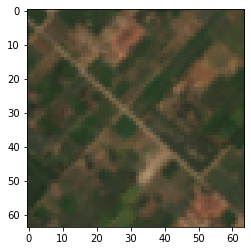

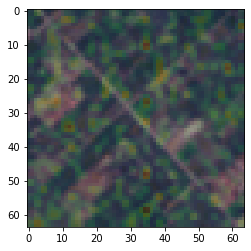

In [97]:
idx=5
batch=int(np.floor(idx/32))
best_input_rgb=best_inputs[batch][idx%32][1:4,:,:][[2,1,0],:,:]
plt.figure()
plt.imshow(np.transpose(best_input_rgb,(1,2,0))*3)
plt.figure()
plt.imshow(np.swapaxes(best_input_rgb,0,2)*3)
plt.imshow(skimage.transform.resize(final_cam_outputs[idx].reshape(32,32,2), (64,64,1)), alpha=.15, cmap='jet')


In [ ]:
print(list(best_labels).count([1.]))

In [ ]:
tp=0
fp=0
tn=0
fn=0
for idx in range(len(best_outputs)):
    if math.floor(best_outputs[idx]/.99) != int(best_labels[idx][0]) and int(best_labels[idx][0])==0:
        fp+=1
    elif math.floor(best_outputs[idx]/.99) != int(best_labels[idx][0]) and int(best_labels[idx][0])==1:
        fn+=1
    elif math.floor(best_outputs[idx]/.99) == int(best_labels[idx][0]) and int(best_labels[idx][0])==0:
        tn+=1
    elif math.floor(best_outputs[idx]/.99) == int(best_labels[idx][0]) and int(best_labels[idx][0])==1:
        tp+=1
print('tp',tp,'fp',fp,'tn',tn,'fn',fn)

In [ ]:
plt.clf()
test=[math.floor(best_outputs[idx]/.99) for idx in range(len(best_outputs))]
errors= [idx for idx in range(len(best_outputs)) if test[idx]!=int(best_labels[idx][0])]
for x in errors:
    batch = math.floor(x/32)
    idx = x % 32
    rgb_image=best_inputs[batch][idx][1:4]
    buff0=rgb_image[0]
    buff1=rgb_image[2]
    rgb_image[0]=buff1
    rgb_image[2]=buff0
    plt.figure()
    plt.imshow(np.swapaxes(rgb_image*3,0,2))
    plt.title('Label'+str(best_labels[x])+'Output'+str(test[x]))

In [ ]:
plt.clf()

In [ ]:
print('Best:',best_val_acc, best_val_loss)
print('Last:',final_val_acc, final_val_loss)